# **Environment Setup**

In [2]:
!git clone https://github.com/itakurah/Focal-loss-PyTorch.git
%pip install fvcore

import sys
sys.path.append('./Focal-loss-PyTorch')

fatal: destination path 'Focal-loss-PyTorch' already exists and is not an empty directory.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# --- 📁 Mount Google Drive ---
#from google.colab import drive
#drive.mount('/content/drive')

# --- 📦 Install Required Libraries ---
#!pip install PyWavelets brevitas torchinfo #imbalanced-learn

#!pip install onnx onnxoptimizer

# --- 📚 Imports ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import pywt
from collections import defaultdict, Counter

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

from focal_loss import FocalLoss  

from torchinfo import summary
import brevitas.nn as qnn
from brevitas.quant import Int8WeightPerTensorFloat, Int8ActPerTensorFloat


In [4]:
# # --- 🛠️ Configuration ---
# DATA_DIR = '/content/drive/MyDrive/Master/Data/merged_output'
# SAVE_DIR = '/content/drive/MyDrive/Master/Data/preprocessed/'
# os.makedirs(SAVE_DIR, exist_ok=True)

# Valid labels for raw input (before AAMI conversion)
VALID_RAW_LABELS = [
    'N', '·', 'L', 'R', 'e', 'j',
    'A', 'a', 'J', 'S',
    'V', 'E',
    'F',
    '/', 'f', 'Q', '[', ']', '!', 'x', '|'
]

# AAMI Class Mapping
AAMI_CLASSES = {
    'N': ['N', '·', 'L', 'R', 'e', 'j'],
    'S': ['A', 'a', 'J', 'S'],
    'V': ['V', 'E'],
    'F': ['F'],
    'Q': ['/', 'f', 'Q', '[', ']', '!', 'x', '|']
}

# Generate AAMI_MAP from AAMI_CLASSES
AAMI_MAP = {}
for aami_label, raw_list in AAMI_CLASSES.items():
    for raw_label in raw_list:
        AAMI_MAP[raw_label] = aami_label

AAMI_CLASS_NAMES = list(AAMI_CLASSES.keys())  # ['N', 'S', 'V', 'F', 'Q']


## **Load Train, Val, Test made from Colab**

In [5]:
save_dir = '/home/eveneiha/finn/workspace/ml/data/preprocessed'

train_data = torch.load(os.path.join(save_dir, "train.pt"))
train_inputs = train_data["inputs"]
train_labels = train_data["labels"]
train_ids = train_data["window_ids"]

val_data = torch.load(os.path.join(save_dir, "val.pt"))
val_inputs = val_data["inputs"]
val_labels = val_data["labels"]
val_ids = val_data["window_ids"]

test_data = torch.load(os.path.join(save_dir, "test.pt"))
test_inputs = test_data["inputs"]
test_labels = test_data["labels"]
test_ids = test_data["window_ids"]

class PreprocessedECGDataset(Dataset):
    def __init__(self, inputs, labels, win_ids):
        self.inputs = inputs
        self.labels = labels
        self.win_ids = win_ids

    def __len__(self):
        return self.inputs.size(0)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx], self.win_ids[idx]

train_dataset = PreprocessedECGDataset(train_inputs, train_labels, train_ids)
val_dataset   = PreprocessedECGDataset(val_inputs, val_labels, val_ids)
test_dataset  = PreprocessedECGDataset(test_inputs, test_labels, test_ids)


batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


/tmp/ipykernel_2307109/2785011069.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(save_dir, "train.pt"))
/tmp/ipykernel_2307109/2785

# **TCN ORIGINAL**

In [6]:
import torch
import torch.nn as nn
import brevitas.nn as qnn
import json 

from brevitas.quant import Int8ActPerTensorFloat, Int8WeightPerTensorFloat

class UnsignedQuantIdentity(qnn.QuantIdentity):
    def forward(self, x):
        qx = super().forward(x)
        clamped_val = torch.clamp(qx.value, 0, 127)  # not 255 because Int8 only allows up to 127
        # Return a new QuantTensor with clamped values
        return qx._replace(value=clamped_val)

# class PickCenter(nn.Module):
#     def __init__(self, C, center_idx=84):
#         super().__init__()
#         self.conv = qnn.QuantConv2d(
#             in_channels=C,
#             out_channels=C,
#             kernel_size=(168, 1),  # span entire sequence
#             stride=(1, 1),
#             groups=C,
#             bias=False,
#             weight_quant=Int8WeightPerTensorFloat,
#             input_quant=Int8ActPerTensorFloat,
#             weight_bit_width=8,
#             act_bit_width=8,
#         )
#         with torch.no_grad():
#             W = torch.zeros(C, 1, 168, 1)
#             W[:, 0, center_idx, 0] = 1.0  # select only the center
#             self.conv.weight.copy_(W)

#     def forward(self, x):
#         return self.conv(x)

# Load the pruning index map
with open("relevant_indices_per_layer.json") as f:
    pruning_map = json.load(f)



def calculate_receptive_field(layers):
    """
    Compute the receptive field given a sequence of convolution layers.

    Parameters:
      layers (list of dict): Each dictionary should contain:
          - 'kernel_size': The size of the kernel (int)
          - 'dilation': The dilation factor (int; default 1 if not provided)
          - 'stride': The stride used (int; default 1 if not provided)

    Returns:
      int: The overall receptive field (number of input time steps covered by the central output)
    """
    receptive_field = 1  # start with a single input point
    jump = 1             # initial jump (distance between successive receptive field centers)

    for i, layer in enumerate(layers):
        ks = layer['kernel_size']
        dilation = layer.get('dilation', 1)
        stride = layer.get('stride', 1)
        # Calculate effective kernel size for this layer:
        effective_kernel_size = (ks - 1) * dilation + 1

        # Update receptive field
        receptive_field += (effective_kernel_size - 1) * jump

        # Update jump (effective stride from the input perspective)
        jump *= stride

        # Optional: print intermediate values for debugging/understanding
        print(f"Layer {i+1}: kernel_size={ks}, dilation={dilation}, stride={stride}, "
              f"effective_kernel_size={effective_kernel_size}, jump={jump}, "
              f"receptive_field={receptive_field}")

    return receptive_field

class SliceSelector(nn.Module):
    def __init__(self, name = None):
        super().__init__()
        
        if name != None:
            self.indices = pruning_map[name]  # Default is no slicing
        else:
            self.indices = None
            
    def forward(self, x):
        if self.indices is None:
            return x
        self.indices = torch.tensor(self.indices, dtype=torch.long)

        #return x[:, :, self.indices[0]: self.indices[-1], :]
        return torch.index_select(x, dim=2, index=self.indices) 

class TemporalBlock2d(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, dilation, stride, dropout=0.2, slice_name= None):
        super(TemporalBlock2d, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.stride = stride
            
        self.conv1 = qnn.QuantConv2d(
            n_inputs, n_outputs,
            kernel_size=(kernel_size, 1),
            stride=(stride, 1),
            padding=(0, 0),  # no padding – only compute valid outputs
            dilation=(dilation, 1),
            weight_quant=Int8WeightPerTensorFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(n_outputs)
        self.dropout1 = nn.Dropout(dropout)

        if slice_name is not None:
            dilation = 1
            
        self.conv2 = qnn.QuantConv2d(
            n_outputs, n_outputs,
            kernel_size=(kernel_size, 1),
            stride=(1, 1),
            padding=(0, 0),
            dilation=(dilation, 1),
            weight_quant=Int8WeightPerTensorFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )
        
        self.bn2 = nn.BatchNorm2d(n_outputs)
        self.dropout2 = nn.Dropout(dropout)

        self.relu_after_conv = qnn.QuantReLU(return_quant_tensor=True)
        self.slice_selector = SliceSelector(slice_name) 


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        #print(x.shape)
        x = self.slice_selector(x) # only on for the final block 
        #print(x.shape)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu_after_conv(x).value
        x = self.dropout2(x)
        return x


class TCN2d(nn.Module):
    def __init__(self, custom_blocks: list, num_outputs: int):
        super(TCN2d, self).__init__()
        self.temporal_blocks = nn.ModuleList(custom_blocks)
        last_out_channels = custom_blocks[-1].conv2.out_channels
                 
        
        # We also need a 1x1 conv to get to num_outputs
        self.fc = qnn.QuantConv2d(
            in_channels=last_out_channels,
            out_channels=num_outputs,
            kernel_size=(1, 1),
            weight_quant=Int8WeightPerTensorFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )
        
        
        C = last_out_channels
        center_idx = 84 # 0-based index
        #self.pick_center = PickCenter(C, center_idx=center_idx)
        

        self.reduce = qnn.QuantConv2d(
            in_channels=last_out_channels,
            out_channels=last_out_channels,
            kernel_size=(168, 1),  # or use known dims if static
            weight_quant=Int8WeightPerTensorFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )
                
        # Input quant layer
        self.inp_quant = qnn.QuantIdentity(
            bit_width=8,
            act_quant=Int8ActPerTensorFloat,
            return_quant_tensor=True
        )

        self.output_quant = UnsignedQuantIdentity(
            bit_width=8,
            act_quant=Int8ActPerTensorFloat,  # still using Int8 under the hood
            return_quant_tensor=True
        )

    def forward(self, x):
        # x = self.inp_quant(x).value
        #x = x[:, :, 0:833, :]  # 0-based index
        qx = self.inp_quant(x)
        #print("🔍 Colab - Quantized Input Scale:", qx.scale)
        #print("🔍 Colab - Quantized Input (approx INT8):", (qx.value / qx.scale).round().clamp(-128, 127)[0, :10, 0, 0])
        #print(qx)
        x = qx.value

        for block in self.temporal_blocks:
            x = block(x)
        x = self.reduce(x)
        #x = x[:, :, 84:85, :]  # 0-based index
        x = self.fc(x)
        x = self.output_quant(x).value
        x = x.reshape(x.size(0), -1)


        return x
    
    

block1 = TemporalBlock2d(1, 4, kernel_size=9, dilation=1,  stride=2,  dropout=0.05)
block2 = TemporalBlock2d(4, 8, kernel_size=9, dilation=4,  stride=1,  dropout=0.05)
block3 = TemporalBlock2d(8, 16, kernel_size=9, dilation=16,  stride=1,  dropout=0.05)

print(pruning_map["block3_conv2"])
print(pruning_map["block2_conv2"])

custom_blocks = [block1, block2, block3]

layers = [
    {'kernel_size': 9, 'dilation': 1,  'stride': 2},  # Block 1 - Conv1
    {'kernel_size': 9, 'dilation': 1,  'stride': 1},  # Block 1 - Conv2
    {'kernel_size': 9, 'dilation': 4,  'stride': 1},  # Block 2 - Conv1
    {'kernel_size': 9, 'dilation': 4,  'stride': 1},  # Block 2 - Conv2
    {'kernel_size': 9, 'dilation': 16, 'stride': 1},  # Block 3 - Conv1
    {'kernel_size': 9, 'dilation': 16, 'stride': 1},  # Block 3 - Conv2
]

rf = calculate_receptive_field(layers)
print(f"\nFinal receptive field: {rf} input time steps")


[84, 100, 116, 132, 148, 164, 180, 196, 212]
[84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308, 312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360, 364, 368, 372]
Layer 1: kernel_size=9, dilation=1, stride=2, effective_kernel_size=9, jump=2, receptive_field=9
Layer 2: kernel_size=9, dilation=1, stride=1, effective_kernel_size=9, jump=2, receptive_field=25
Layer 3: kernel_size=9, dilation=4, stride=1, effective_kernel_size=33, jump=2, receptive_field=89
Layer 4: kernel_size=9, dilation=4, stride=1, effective_kernel_size=33, jump=2, receptive_field=153
Layer 5: kernel_size=9, dilation=16, stride=1, effective_kernel_size=129, jump=2, receptive_field=409
Layer 6: kernel_size=9, dilation=16, stride=1, effective_kernel_size=129, jump=2, receptive_field

## **SETUP TRAINING** 

In [7]:
lr = 0.007

# Instantiate model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TCN2d(custom_blocks=custom_blocks, num_outputs=5).to(device)
# model = TCN2dWithPositionalWeighting(
#     custom_blocks=custom_blocks,
#     num_outputs=5,
#     input_length=665,
#     use_learnable_weights=False
# ).to(device)


inputs = test_data["inputs"]

sample = inputs[1].unsqueeze(0)

finn_sample = sample.permute(0,2,3,1)
np.save("/home/eveneiha/finn/workspace/ml/data/finn_sample.npy", finn_sample.numpy())

# from google.colab import files
# files.download('finn_sample.npy')




# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

num_classes = 5
alpha = [1.0] * num_classes  # Example class weights
criterion = FocalLoss(gamma=3, alpha=alpha, task_type='multi-class', num_classes=num_classes)

summary(model, input_size=(1, 1, 1000, 1))#833  # (batch_size, channels, sequence_length)
#summary(model, input_data=sample.to(device))




/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/_tensor.py:1413: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1925.)
  return super().rename(names)
/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                                                      Output Shape              Param #
TCN2d                                                                       [1, 5]                    --
├─QuantIdentity: 1-1                                                        [1, 1, 1000, 1]           --
│    └─ActQuantProxyFromInjector: 2-1                                       [1, 1, 1000, 1]           --
│    └─ActQuantProxyFromInjector: 2-2                                       [1, 1, 1000, 1]           --
│    │    └─FusedActivationQuantProxy: 3-1                                  [1, 1, 1000, 1]           1
├─UnsignedQuantIdentity: 1-27                                               --                        (recursive)
│    └─ActQuantProxyFromInjector: 2-32                                      --                        (recursive)
│    │    └─FusedActivationQuantProxy: 3-51                                 --                        (recursive)
├─QuantIdentity: 1-3    

## **Training**

In [9]:
# --- Load Model ---

# CPU:
checkpoint = torch.load('./tcn_model_v41.pth', map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'], strict=False)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # If needed
model.eval()


/tmp/ipykernel_2307109/802073669.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./tcn_model_v41.pth', map_location=torch.device('cpu'))


ValueError: loaded state dict contains a parameter group that doesn't match the size of optimizer's group

In [10]:
# --- Training Parameters ---
num_epochs = 10
training_losses = []
validation_losses = []

model.train()  # Set model to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    batch_count = 0

    # Training loop over batches
    for inputs, targets, _ in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)
        loss.backward()         # Backpropagation
        optimizer.step()        # Update weights

        running_loss += loss.item()
        batch_count += 1

    train_loss = running_loss / batch_count
    training_losses.append(train_loss)

    # --- Validation ---
    model.eval()  # Switch to evaluation mode
    val_running_loss = 0.0
    val_batch_count = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs_val, targets_val, _ in val_dataloader:
            inputs_val = inputs_val.to(device)
            targets_val = targets_val.to(device)
            outputs_val = model(inputs_val)
            loss_val = criterion(outputs_val, targets_val)

            val_running_loss += loss_val.item()
            val_batch_count += 1

            # Compute accuracy for the batch
            _, predicted = torch.max(outputs_val, 1)
            correct += (predicted == targets_val).sum().item()
            total += targets_val.size(0)

    val_loss = val_running_loss / val_batch_count
    validation_losses.append(val_loss)
    val_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    model.train()  # Switch back to training mode for the next epoch


Epoch 1/10 - Train Loss: 0.0392, Val Loss: 0.0387, Val Acc: 0.8877
Epoch 2/10 - Train Loss: 0.0285, Val Loss: 0.0242, Val Acc: 0.9240
Epoch 3/10 - Train Loss: 0.0257, Val Loss: 0.0239, Val Acc: 0.9351
Epoch 4/10 - Train Loss: 0.0247, Val Loss: 0.0257, Val Acc: 0.9398
Epoch 5/10 - Train Loss: 0.0257, Val Loss: 0.0263, Val Acc: 0.9343
Epoch 6/10 - Train Loss: 0.0263, Val Loss: 0.0247, Val Acc: 0.9407
Epoch 7/10 - Train Loss: 0.0262, Val Loss: 0.0244, Val Acc: 0.9416
Epoch 8/10 - Train Loss: 0.0254, Val Loss: 0.0241, Val Acc: 0.9325
Epoch 9/10 - Train Loss: 0.0262, Val Loss: 0.0278, Val Acc: 0.8877
Epoch 10/10 - Train Loss: 0.0277, Val Loss: 0.0273, Val Acc: 0.9320


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,



📈 Test Loss: 0.0273
✅ Test Accuracy: 0.9325


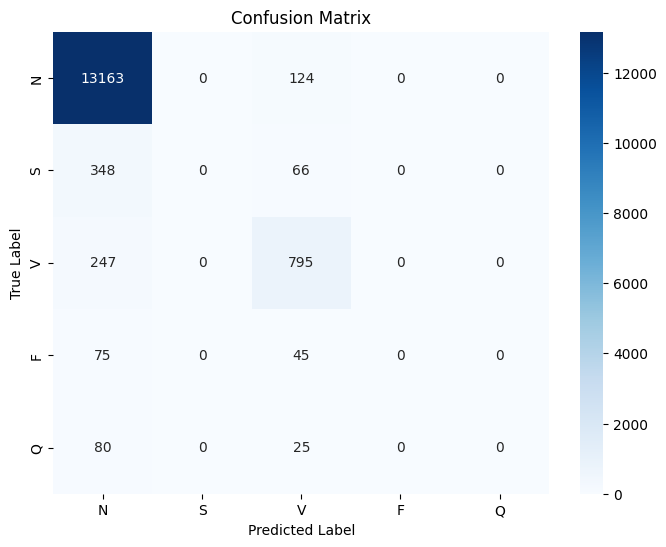

📋 Classification Report:
              precision    recall  f1-score   support

           N       0.95      0.99      0.97     13287
           S       0.00      0.00      0.00       414
           V       0.75      0.76      0.76      1042
           F       0.00      0.00      0.00       120
           Q       0.00      0.00      0.00       105

    accuracy                           0.93     14968
   macro avg       0.34      0.35      0.35     14968
weighted avg       0.89      0.93      0.91     14968



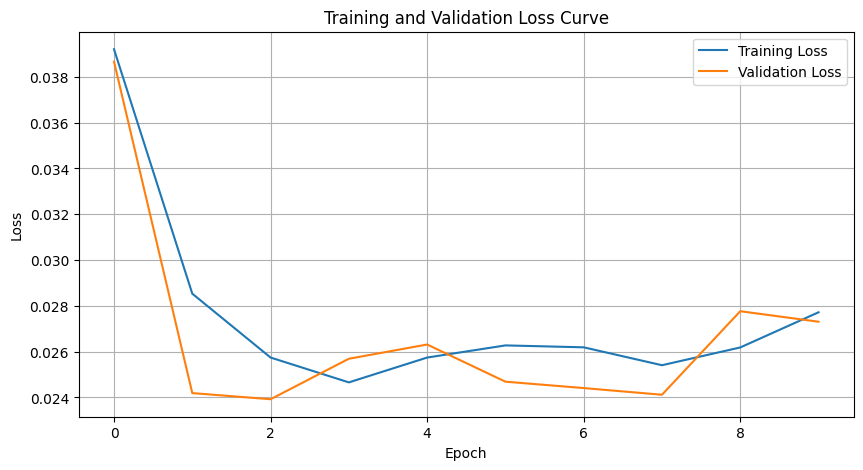

📊 Macro F1-Score: 0.3452
📊 Weighted F1-Score: 0.9120


In [11]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score


# Initialize the nested mapping:
# Structure: { predicted_label (str): { true_label (str): [window_id, window_id, ...] } }
misclassified_map = defaultdict(lambda: defaultdict(list))

model.eval()  # Set model to evaluation mode

all_preds = []
all_targets = []
test_loss = 0.0
correct = 0
total = 0

# If needed for other purposes, you can keep lists of misclassified tensors.
misclassified_inputs = []
misclassified_preds = []
misclassified_targets = []

with torch.no_grad():
    # Here, we assume test_dataloader returns (inputs, targets, window_ids)
    for inputs, targets, win_ids in test_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

        # Create a boolean mask for misclassified samples.
        misclassified_mask = predicted != targets
        if misclassified_mask.any():
            # (Optional) Save misclassified tensors if desired:
            misclassified_inputs.extend(inputs[misclassified_mask].cpu())
            misclassified_preds.extend(predicted[misclassified_mask].cpu())
            misclassified_targets.extend(targets[misclassified_mask].cpu())

            # Loop over the current batch and store misclassified window IDs.
            # Note: win_ids is assumed to be a list (or tensor) of window IDs corresponding to the batch.
            # We convert misclassified_mask to CPU and then iterate over indices.
            mis_mask_cpu = misclassified_mask.cpu()
            # For each index in the batch:
            for i in range(len(win_ids)):
                if mis_mask_cpu[i].item():
                    # Convert numeric labels to strings using AAMI_CLASS_NAMES.
                    pred_label = AAMI_CLASS_NAMES[predicted[i].item()]
                    true_label = AAMI_CLASS_NAMES[targets[i].item()]
                    win_id = win_ids[i]
                    misclassified_map[pred_label][true_label].append(win_id)

test_loss /= len(test_dataloader)
test_accuracy = correct / total

print(f"\n📈 Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

# Plotting Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=AAMI_CLASS_NAMES,
            yticklabels=AAMI_CLASS_NAMES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("📋 Classification Report:")
print(classification_report(all_targets, all_preds, target_names=AAMI_CLASS_NAMES, zero_division=0))


# Plotting Training and Validation Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(len(training_losses)), training_losses, label='Training Loss')
plt.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

macro_f1 = f1_score(all_targets, all_preds, average="macro")
weighted_f1 = f1_score(all_targets, all_preds, average="weighted")

print(f"📊 Macro F1-Score: {macro_f1:.4f}")
print(f"📊 Weighted F1-Score: {weighted_f1:.4f}")

## **SAVE WEIGHTS FOR INFERENCE MODEL**

In [79]:
# --- Save model ---

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # If you want to save optimizer state
}, './tcn_model_v41.pth')

print("Training Done, model weights are saved")


Training Done, model weights are saved


## **Export onnx** 

In [20]:
# --- Export Model ---
from brevitas.export import export_qonnx

model.eval()
model = model.to(device)
dummy_input = torch.randn(1, 1, 1000, 1).to(device)

export_qonnx(model, dummy_input, export_path='/home/eveneiha/finn/workspace/finn/onnx/tcn_v41.onnx', opset_version=11)



# export_qonnx(model, dummy_input, export_path='tcn_v41.onnx', opset_version=9)

# from google.colab import files
# files.download('tcn_v41.onnx')
#files.download('test.pt')

ir_version: 6
producer_name: "pytorch"
producer_version: "2.4.1"
graph {
  node {
    input: "x.679"
    input: "/inp_quant/act_quant/export_handler/Constant_1_output_0"
    input: "/inp_quant/act_quant/export_handler/Constant_2_output_0"
    input: "/inp_quant/act_quant/export_handler/Constant_output_0"
    output: "/inp_quant/act_quant/export_handler/Quant_output_0"
    name: "/inp_quant/act_quant/export_handler/Quant"
    op_type: "Quant"
    attribute {
      name: "narrow"
      i: 0
      type: INT
    }
    attribute {
      name: "rounding_mode"
      s: "ROUND"
      type: STRING
    }
    attribute {
      name: "signed"
      i: 1
      type: INT
    }
    domain: "onnx.brevitas"
  }
  node {
    input: "/inp_quant/act_quant/export_handler/Quant_output_0"
    input: "/temporal_blocks.0/conv1/input_quant/export_handler/Constant_output_0"
    input: "/inp_quant/act_quant/export_handler/Constant_2_output_0"
    input: "/inp_quant/act_quant/export_handler/Constant_output_0"
    

# **TCN_INFERENCE MODULE**

In [14]:
import torch
import torch.nn as nn
import brevitas.nn as qnn
import json 

from brevitas.quant import Int8ActPerTensorFloat, Int8WeightPerTensorFloat


# Load the pruning index map
with open("relevant_indices_per_layer.json") as f:
    pruning_map = json.load(f)


class UnsignedQuantIdentity(qnn.QuantIdentity):
    def forward(self, x):
        qx = super().forward(x)
        clamped_val = torch.clamp(qx.value, 0, 127)  # not 255 because Int8 only allows up to 127
        # Return a new QuantTensor with clamped values
        return qx._replace(value=clamped_val)


class SliceSelector(nn.Module):
    def __init__(self, name = None):
        super().__init__()
        
        if name != None:
            self.indices = pruning_map[name]  # Default is no slicing
        else:
            self.indices = None
            
    def forward(self, x):
        if self.indices is None:
            return x
        self.indices = torch.tensor(self.indices, dtype=torch.long, device=x.device)

        #return x[:, :, self.indices[0]: self.indices[-1], :]
        return x[:, :, self.indices, :] #torch.index_select(x, dim=2, index=self.indices) 


class TemporalBlock2d_inf(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, dilation, stride, dropout=0.2, slice_name= None):
        super(TemporalBlock2d_inf, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.stride = stride
            
        self.conv1 = qnn.QuantConv2d(
            n_inputs, n_outputs,
            kernel_size=(kernel_size, 1),
            stride=(stride, 1),
            padding=(0, 0),  # no padding – only compute valid outputs
            dilation=(dilation, 1),
            weight_quant=Int8WeightPerTensorFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(n_outputs)
        self.dropout1 = nn.Dropout(dropout)

        if slice_name is not None:
            dilation = 1
            
        self.conv2 = qnn.QuantConv2d(
            n_outputs, n_outputs,
            kernel_size=(kernel_size, 1),
            stride=(1, 1),
            padding=(0, 0),
            dilation=(dilation, 1),
            weight_quant=Int8WeightPerTensorFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )
        
        self.bn2 = nn.BatchNorm2d(n_outputs)
        self.dropout2 = nn.Dropout(dropout)

        self.relu_after_conv = qnn.QuantReLU(return_quant_tensor=True)
        self.slice_selector = SliceSelector(slice_name) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.slice_selector(x) 

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu_after_conv(x).value
        x = self.dropout2(x)
        return x


class TCN2d_inf(nn.Module):
    def __init__(self, custom_blocks: list, num_outputs: int):
        super(TCN2d_inf, self).__init__()
        self.temporal_blocks = nn.ModuleList(custom_blocks)
        last_out_channels = custom_blocks[-1].conv2.out_channels
                 
        self.fc = qnn.QuantConv2d(
            in_channels=last_out_channels,
            out_channels=num_outputs,
            kernel_size=(1, 1),
            weight_quant=Int8WeightPerTensorFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )
                
        # Input quant layer
        self.inp_quant = qnn.QuantIdentity(
            bit_width=8,
            act_quant=Int8ActPerTensorFloat,
            return_quant_tensor=True
        )

        self.output_quant = UnsignedQuantIdentity(
            bit_width=8,
            act_quant=Int8ActPerTensorFloat,  # still using Int8 under the hood
            return_quant_tensor=True
        )

    def forward(self, x):
        # x = self.inp_quant(x).value
        x = x[:, :, 0:833, :]  # 0-based index
        
        
        
        qx = self.inp_quant(x)

        x = qx.value

        for block in self.temporal_blocks:
            x = block(x)

        x = self.fc(x)
        x = self.output_quant(x).value
        x = x.reshape(x.size(0), -1)


        return x
    
    

block1 = TemporalBlock2d_inf(1, 4, kernel_size=9, dilation=1,  stride=2,  dropout=0.05, slice_name="block1_conv2")
block2 = TemporalBlock2d_inf(4, 8, kernel_size=9, dilation=4,  stride=1,  dropout=0.05)
block3 = TemporalBlock2d_inf(8, 16, kernel_size=9, dilation=16,  stride=1,  dropout=0.05) #slice_name="block3_conv2")

print(pruning_map["block3_conv2"])
print(pruning_map["block2_conv2"])

custom_blocks_inf = [block1, block2, block3]

layers = [
    {'kernel_size': 9, 'dilation': 1,  'stride': 2},  # Block 1 - Conv1
    {'kernel_size': 9, 'dilation': 1,  'stride': 1},  # Block 1 - Conv2
    {'kernel_size': 9, 'dilation': 4,  'stride': 1},  # Block 2 - Conv1
    {'kernel_size': 9, 'dilation': 4,  'stride': 1},  # Block 2 - Conv2
    {'kernel_size': 9, 'dilation': 16, 'stride': 1},  # Block 3 - Conv1
    {'kernel_size': 9, 'dilation': 16, 'stride': 1},  # Block 3 - Conv2
]

rf = calculate_receptive_field(layers)
print(f"\nFinal receptive field: {rf} input time steps")


[84, 100, 116, 132, 148, 164, 180, 196, 212]
[84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308, 312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360, 364, 368, 372]
Layer 1: kernel_size=9, dilation=1, stride=2, effective_kernel_size=9, jump=2, receptive_field=9
Layer 2: kernel_size=9, dilation=1, stride=1, effective_kernel_size=9, jump=2, receptive_field=25
Layer 3: kernel_size=9, dilation=4, stride=1, effective_kernel_size=33, jump=2, receptive_field=89
Layer 4: kernel_size=9, dilation=4, stride=1, effective_kernel_size=33, jump=2, receptive_field=153
Layer 5: kernel_size=9, dilation=16, stride=1, effective_kernel_size=129, jump=2, receptive_field=409
Layer 6: kernel_size=9, dilation=16, stride=1, effective_kernel_size=129, jump=2, receptive_field

In [15]:

# Instantiate model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print([type(block) for block in custom_blocks_inf])
model_inf = TCN2d_inf(custom_blocks=custom_blocks_inf, num_outputs=5).to(device)

summary(model_inf, input_size=(1, 1, 1000, 1))#833  # (batch_size, channels, sequence_length)
#summary(model, input_data=sample.to(device))




[<class '__main__.TemporalBlock2d_inf'>, <class '__main__.TemporalBlock2d_inf'>, <class '__main__.TemporalBlock2d_inf'>]


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                                                      Output Shape              Param #
TCN2d_inf                                                                   [1, 5]                    --
├─QuantIdentity: 1-1                                                        [1, 1, 833, 1]            --
│    └─ActQuantProxyFromInjector: 2-1                                       [1, 1, 833, 1]            --
│    └─ActQuantProxyFromInjector: 2-2                                       [1, 1, 833, 1]            --
│    │    └─FusedActivationQuantProxy: 3-1                                  [1, 1, 833, 1]            1
├─UnsignedQuantIdentity: 1-24                                               --                        (recursive)
│    └─ActQuantProxyFromInjector: 2-27                                      --                        (recursive)
│    │    └─FusedActivationQuantProxy: 3-47                                 --                        (recursive)
├─QuantIdentity: 1-3    

## **LOAD WEIGHTS FROM UNPRUNED MODEL**

In [16]:
# --- Load Model ---

# CPU:
checkpoint = torch.load('./tcn_model_v41.pth', map_location=torch.device('cpu'))

model_inf.load_state_dict(checkpoint['model_state_dict'], strict=False)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # If needed
model_inf.eval()


/tmp/ipykernel_2307109/1290164518.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./tcn_model_v41.pth', map_location=torch.device('cpu'))


ValueError: loaded state dict contains a parameter group that doesn't match the size of optimizer's group

/tmp/ipykernel_2154775/1697987538.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.indices = torch.tensor(self.indices, dtype=torch.long)



📈 Test Loss: 0.0045
✅ Test Accuracy: 0.9711


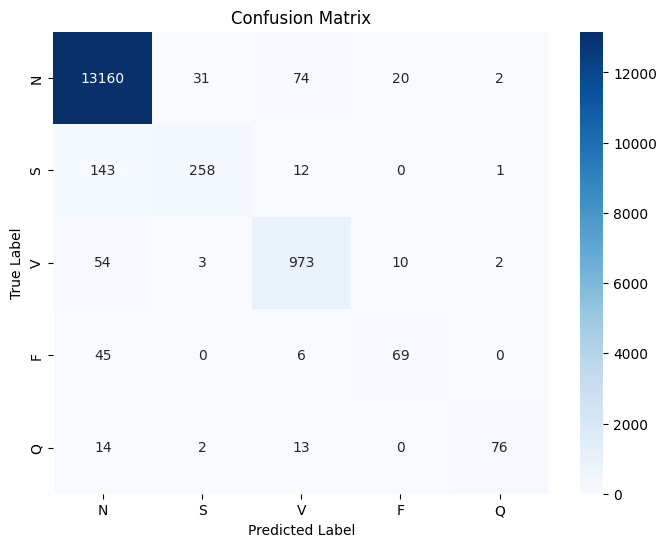

📋 Classification Report:
              precision    recall  f1-score   support

           N       0.98      0.99      0.99     13287
           S       0.88      0.62      0.73       414
           V       0.90      0.93      0.92      1042
           F       0.70      0.57      0.63       120
           Q       0.94      0.72      0.82       105

    accuracy                           0.97     14968
   macro avg       0.88      0.77      0.82     14968
weighted avg       0.97      0.97      0.97     14968



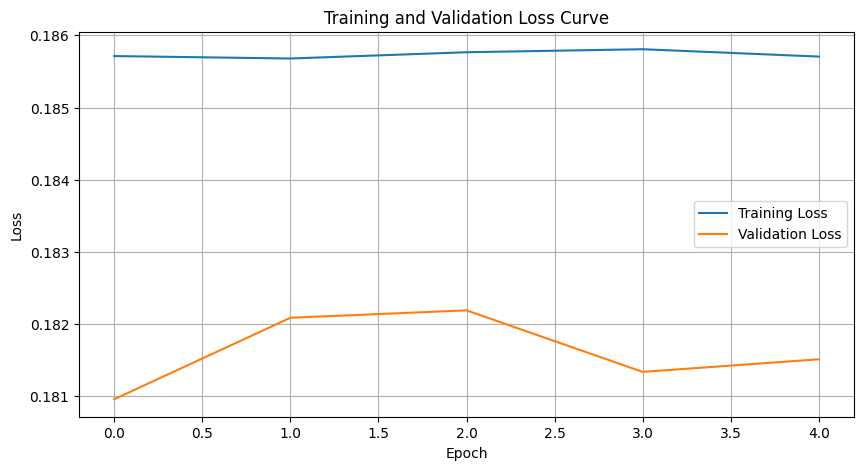

📊 Macro F1-Score: 0.8159
📊 Weighted F1-Score: 0.9698


In [94]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score


# Initialize the nested mapping:
# Structure: { predicted_label (str): { true_label (str): [window_id, window_id, ...] } }
misclassified_map = defaultdict(lambda: defaultdict(list))

model_inf.eval()  # Set model to evaluation mode

all_preds = []
all_targets = []
test_loss = 0.0
correct = 0
total = 0

# If needed for other purposes, you can keep lists of misclassified tensors.
misclassified_inputs = []
misclassified_preds = []
misclassified_targets = []

with torch.no_grad():
    # Here, we assume test_dataloader returns (inputs, targets, window_ids)
    for inputs, targets, win_ids in test_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model_inf(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

        # Create a boolean mask for misclassified samples.
        misclassified_mask = predicted != targets
        if misclassified_mask.any():
            # (Optional) Save misclassified tensors if desired:
            misclassified_inputs.extend(inputs[misclassified_mask].cpu())
            misclassified_preds.extend(predicted[misclassified_mask].cpu())
            misclassified_targets.extend(targets[misclassified_mask].cpu())

            # Loop over the current batch and store misclassified window IDs.
            # Note: win_ids is assumed to be a list (or tensor) of window IDs corresponding to the batch.
            # We convert misclassified_mask to CPU and then iterate over indices.
            mis_mask_cpu = misclassified_mask.cpu()
            # For each index in the batch:
            for i in range(len(win_ids)):
                if mis_mask_cpu[i].item():
                    # Convert numeric labels to strings using AAMI_CLASS_NAMES.
                    pred_label = AAMI_CLASS_NAMES[predicted[i].item()]
                    true_label = AAMI_CLASS_NAMES[targets[i].item()]
                    win_id = win_ids[i]
                    misclassified_map[pred_label][true_label].append(win_id)

test_loss /= len(test_dataloader)
test_accuracy = correct / total

print(f"\n📈 Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

# Plotting Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=AAMI_CLASS_NAMES,
            yticklabels=AAMI_CLASS_NAMES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("📋 Classification Report:")
print(classification_report(all_targets, all_preds, target_names=AAMI_CLASS_NAMES, zero_division=0))


# Plotting Training and Validation Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(len(training_losses)), training_losses, label='Training Loss')
plt.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

macro_f1 = f1_score(all_targets, all_preds, average="macro")
weighted_f1 = f1_score(all_targets, all_preds, average="weighted")

print(f"📊 Macro F1-Score: {macro_f1:.4f}")
print(f"📊 Weighted F1-Score: {weighted_f1:.4f}")

In [25]:
from brevitas.export import export_qonnx

model_inf.eval()
model_inf = model_inf.to(device)
dummy_input = torch.randn(1, 1, 1000, 1).to(device)

export_qonnx(model_inf, dummy_input, export_path='/home/eveneiha/finn/workspace/finn/onnx/tcn_v41_inf.onnx', opset_version=11)

torch.Size([1, 4, 413, 1])
torch.Size([1, 4, 329, 1])
torch.Size([1, 8, 289, 1])
torch.Size([1, 8, 289, 1])
torch.Size([1, 16, 129, 1])
torch.Size([1, 16, 129, 1])
torch.Size([1, 4, 413, 1])
torch.Size([1, 4, 329, 1])
torch.Size([1, 8, 289, 1])
torch.Size([1, 8, 289, 1])
torch.Size([1, 16, 129, 1])
torch.Size([1, 16, 129, 1])


ir_version: 6
producer_name: "pytorch"
producer_version: "2.4.1"
graph {
  node {
    input: "onnx::Slice_0"
    input: "/Constant_1_output_0"
    input: "/Constant_2_output_0"
    input: "/Constant_output_0"
    input: "/Constant_3_output_0"
    output: "/Slice_output_0"
    name: "/Slice"
    op_type: "Slice"
  }
  node {
    input: "/Slice_output_0"
    input: "/inp_quant/act_quant/export_handler/Constant_1_output_0"
    input: "/inp_quant/act_quant/export_handler/Constant_2_output_0"
    input: "/inp_quant/act_quant/export_handler/Constant_output_0"
    output: "/inp_quant/act_quant/export_handler/Quant_output_0"
    name: "/inp_quant/act_quant/export_handler/Quant"
    op_type: "Quant"
    attribute {
      name: "narrow"
      i: 0
      type: INT
    }
    attribute {
      name: "rounding_mode"
      s: "ROUND"
      type: STRING
    }
    attribute {
      name: "signed"
      i: 1
      type: INT
    }
    domain: "onnx.brevitas"
  }
  node {
    input: "/inp_quant/act_quant/

# **MODEL TIME COMPARISON**

In [17]:

import torch
import time
from fvcore.nn import FlopCountAnalysis, parameter_count_table

def benchmark_model(model, input_tensor, name="Model", runs=100, warmup=10, verbose=True):
    model.eval()
    input_tensor = input_tensor.to(next(model.parameters()).device)

    # Warmup
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(input_tensor)

    # Measure inference time
    times = []
    with torch.no_grad():
        for _ in range(runs):
            start = time.time()
            _ = model(input_tensor)
            end = time.time()
            times.append(end - start)

    avg_time_ms = 1000 * sum(times) / len(times)
    std_time_ms = 1000 * (sum((t - sum(times)/len(times))**2 for t in times) / len(times))**0.5

    # FLOPs
    try:
        flops = FlopCountAnalysis(model, input_tensor)
        total_flops = flops.total()
        flops_breakdown = flops.by_module()
    except Exception as e:
        total_flops = None
        flops_breakdown = None
        if verbose:
            print(f"FLOP analysis failed for {name}: {e}")

    # Parameters
    param_table = parameter_count_table(model)

    if verbose:
        print(f"\n📊 Benchmark for {name}")
        print(f"  ⏱️ Avg Inference Time: {avg_time_ms:.2f} ms ± {std_time_ms:.2f} ms over {runs} runs")
        print(f"  🧮 Parameters:\n{param_table}")
        if total_flops is not None:
            print(f"  🔢 Total FLOPs: {total_flops:,}")
            print(f"  🔍 FLOPs by module (top 5):")
            for module, flop in list(flops_breakdown.items())[:5]:
                print(f"    {module}: {flop:,} FLOPs")

    return {
        "name": name,
        "avg_time_ms": avg_time_ms,
        "std_time_ms": std_time_ms,
        "total_flops": total_flops,
        "param_table": param_table,
        "flops_breakdown": flops_breakdown,
    }


# Dummy example, replace with your actual models and input
model1 = TCN2d(custom_blocks=custom_blocks, num_outputs=5).to(device)  # or .to(device)
model2 = TCN2d_inf(custom_blocks=custom_blocks_inf, num_outputs=5).to(device)
input_tensor = torch.randn(1, 1, 1000, 1).to(device)  # Example input

results_normal = benchmark_model(model1, input_tensor, "Model 1")
results_pruned = benchmark_model(model2, input_tensor, "Model 2")

def print_benchmark_results(*results):
    print("\n===================== 📊 Benchmark Comparison =====================")
    for res in results:
        print(f"\n🔧 {res['name']}")
        print(f"  ⏱️ Avg Inference Time: {res['avg_time_ms']:.2f} ms ± {res['std_time_ms']:.2f} ms")
        if res['total_flops'] is not None:
            print(f"  🔢 Total FLOPs: {res['total_flops']:,}")
        else:
            print("  🔢 Total FLOPs: Not available")
        print(f"  🧮 Parameters:")
        print(res['param_table'])
        if res['flops_breakdown']:
            print(f"  🔍 Top FLOP Modules:")
            for module, flop in list(res['flops_breakdown'].items())[:5]:
                print(f"    {module}: {flop:,} FLOPs")
        print("-" * 70)

print_benchmark_results(results_normal, results_pruned)


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
Unsupported operator aten::sub encountered 99 time(s)
Unsupported operator aten::pow encountered 60 time(s)
Unsupported operator aten::neg encountered 54 time(s)
Unsupported operator aten::div encountered 42 time(s)
Unsupported operator aten::clamp_min encountered 21 time(s)
Unsupported operator aten::abs encountered 21 time(s)
Unsupported operator aten::add encountered 37 time(s)
Unsupported operator aten::round encountered 21 time(s)
Unsupported operator aten::where encountered 42 time(s)
Unsupported operator aten::lt encountered 21 time(s)
Unsupported operator aten::mul encountered 24 time(s)
The following submodules of t


📊 Benchmark for Model 1
  ⏱️ Avg Inference Time: 9.03 ms ± 0.85 ms over 100 runs
  🧮 Parameters:
| name                                                   | #elements or shape   |
|:-------------------------------------------------------|:---------------------|
| model                                                  | 47.7K                |
|  temporal_blocks                                       |  4.6K                |
|   temporal_blocks.0                                    |   0.2K               |
|    temporal_blocks.0.conv1                             |    37                |
|    temporal_blocks.0.bn1                               |    8                 |
|    temporal_blocks.0.conv2                             |    0.1K              |
|    temporal_blocks.0.bn2                               |    8                 |
|    temporal_blocks.0.relu_after_conv                   |    1                 |
|   temporal_blocks.1                                    |   0.9K               |


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
/tmp/ipykernel_2307109/213260099.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.indices = torch.tensor(self.indices, dtype=torch.long, device=x.device)
Unsupported operator aten::sub encountered 89 time(s)
Unsupported operator aten::pow encountered 54 time(s)
Unsupported operator aten::neg encountered 48 time(s)
Unsupported operator aten::div encountered 38 time(s)
Unsupported operator aten::clamp_min encountered 19 time(s)
Unsupported operator aten::abs encountere


📊 Benchmark for Model 2
  ⏱️ Avg Inference Time: 7.45 ms ± 0.66 ms over 100 runs
  🧮 Parameters:
| name                                                   | #elements or shape   |
|:-------------------------------------------------------|:---------------------|
| model                                                  | 4.7K                 |
|  temporal_blocks                                       |  4.6K                |
|   temporal_blocks.0                                    |   0.2K               |
|    temporal_blocks.0.conv1                             |    37                |
|    temporal_blocks.0.bn1                               |    8                 |
|    temporal_blocks.0.conv2                             |    0.1K              |
|    temporal_blocks.0.bn2                               |    8                 |
|    temporal_blocks.0.relu_after_conv                   |    1                 |
|   temporal_blocks.1                                    |   0.9K               |


## **COMPARING KERNEL COMPUTATIONS**

In [103]:
def count_kernel_computations(model, input_tensor):
    """
    Counts the number of kernel applications for QuantConv2d layers
    based on the output shape during a forward pass.

    Args:
        model (nn.Module): The model to analyze.
        input_tensor (torch.Tensor): A sample input tensor.

    Returns:
        list: A list of tuples, where each tuple contains:
              (layer_name, output_shape, kernel_applications)
        dict: A dictionary mapping layer names to the number of applications.
    """
    if input_tensor is None:
        raise ValueError("input_tensor is required for dynamic computation counting.")

    computation_info = []
    layer_outputs = {}
    hooks = []

    def register_hook(name):
        def hook_fn(module, input, output):
            # Store output shape. Output might be QuantTensor, get value shape.
            if hasattr(output, 'value') and isinstance(output.value, torch.Tensor):
                 layer_outputs[name] = output.value.shape
            elif isinstance(output, torch.Tensor):
                 layer_outputs[name] = output.shape
            else:
                 # Handle cases where output might be tuple etc. (less likely for Conv)
                 layer_outputs[name] = "Unknown/Non-Tensor Output"


        return hook_fn

    # Register hooks
    for name, module in model.named_modules():
        if isinstance(module, qnn.QuantConv2d):
            hooks.append(module.register_forward_hook(register_hook(name)))

    # Perform forward pass
    model.eval()
    with torch.no_grad():
        try:
            _ = model(input_tensor.to(next(model.parameters()).device))
        except Exception as e:
            print(f"Error during forward pass for computation counting: {e}")
            # Remove hooks even if forward pass failed
            for h in hooks:
                h.remove()
            return [], {} # Return empty results

    # Remove hooks
    for h in hooks:
        h.remove()

    # Calculate kernel applications
    layer_applications = {}
    for name, module in model.named_modules():
        if isinstance(module, qnn.QuantConv2d):
            if name in layer_outputs and isinstance(layer_outputs[name], torch.Size):
                output_shape = layer_outputs[name]
                # Assumes output shape is (N, C_out, T_out, H_out) or (N, C_out, T_out)
                # Calculate applications = C_out * T_out * H_out (* W_out if applicable)
                # For your TCN2d, it's likely (N, C_out, T_out, 1) -> C_out * T_out * 1
                num_dims = len(output_shape)
                if num_dims >= 3: # Need at least N, C, T
                    C_out = output_shape[1]
                    # Multiply spatial/temporal dimensions starting from index 2
                    spatial_temporal_dims = 1
                    for dim_size in output_shape[2:]:
                        spatial_temporal_dims *= dim_size
                    kernel_apps = C_out * spatial_temporal_dims
                    computation_info.append((name, output_shape, kernel_apps))
                    layer_applications[name] = kernel_apps
                else:
                     computation_info.append((name, output_shape, "N/A (Shape < 3D)"))
                     layer_applications[name] = 0 # Or None

            else:
                 # Layer might not have been called or had non-tensor output
                computation_info.append((name, layer_outputs.get(name, "Not Executed"), 0))
                layer_applications[name] = 0

    return computation_info, layer_applications

def print_computation_summary(model, model_name, input_tensor):
    """Prints the summary of kernel computations."""
    print(f"\n⚙️ Kernel Computation Summary for {model_name}")
    info_list, _ = count_kernel_computations(model, input_tensor)
    total_applications = 0
    if not info_list:
        print("  No QuantConv2d layers found or computation failed.")
        return

    print(f"  {'Layer Name':<30} {'Output Shape':<20} {'Kernel Applications':>20}")
    print(f"  {'-'*30:<30} {'-'*20:<20} {'-'*20:>20}")
    for name, shape, apps in info_list:
        shape_str = str(tuple(shape)) if isinstance(shape, torch.Size) else str(shape)
        apps_str = f"{apps:,}" if isinstance(apps, (int, float)) and apps != "N/A (Shape < 3D)" else str(apps)
        print(f"  {name:<30} {shape_str:<20} {apps_str:>20}")
        if isinstance(apps, (int, float)):
            total_applications += apps
    print(f"  {'-'*30:<30} {'-'*20:<20} {'-'*20:>20}")
    print(f"  {'Total':<30} {' ':<20} {total_applications:>20,}")
    print("-" * 75)


# --- Run the comparison ---
# Use an appropriate input tensor shape for your models
# Input: (Batch, Channels, Time, Height=1) - e.g., (1, 1, 1000, 1) based on your benchmark
# Adjust the time dimension (1000) if needed for your models
input_data = torch.randn(1, 1, 1000, 1).to(device) # Matching your forward pass slice
# input_data = torch.randn(1, 1, rf, 1).to(device) # Or use receptive field size if needed

print_computation_summary(model1, "Model (Standard TCN)", input_data.clone()) # Use clone if input is modified inplace anywhere
print_computation_summary(model2, "Model Inf (With SliceSelector)", input_data.clone())


⚙️ Kernel Computation Summary for Model (Standard TCN)
  Layer Name                     Output Shape          Kernel Applications
  ------------------------------ -------------------- --------------------
  temporal_blocks.0.conv1        (1, 4, 496, 1)                      1,984
  temporal_blocks.0.conv2        (1, 4, 488, 1)                      1,952
  temporal_blocks.1.conv1        (1, 8, 456, 1)                      3,648
  temporal_blocks.1.conv2        (1, 8, 424, 1)                      3,392
  temporal_blocks.2.conv1        (1, 16, 296, 1)                     4,736
  temporal_blocks.2.conv2        (1, 16, 168, 1)                     2,688
  fc                             (1, 5, 1, 1)                            5
  pick_center.conv               (1, 16, 1, 1)                          16
  ------------------------------ -------------------- --------------------
  Total                                                             18,421
--------------------------------------------

/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
/tmp/ipykernel_2154775/1697987538.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.indices = torch.tensor(self.indices, dtype=torch.long)


# **ADDITIONAL DEBUG / OPTIMIZATIONS**

## **Inspect Misses**

In [ ]:
def plot_event(event, predicted_label, dataset, title_label='aami', figsize=(12,4)):
    """
    Plot an ECG window for a given event.

    Parameters:
      - event: a tuple (window_id, filename, ecg_tensor, raw_label, sample_num)
      - predicted_label: the misclassified predicted label (str)
      - dataset: the original dataset, needed to load the full CSV file and metadata
      - title_label: whether to display 'raw' or 'aami' in the title.
      - figsize: Figure size.
    """
    window_id, filename, ecg_tensor, raw_label, sample_num = event
    ecg_np = ecg_tensor.squeeze().numpy()  # the precomputed, resampled window

    # Load the full raw signal and r-peaks from CSV
    full_path = os.path.join(dataset.data_dir, filename)
    df = pd.read_csv(full_path)
    ecg_sig = (df['MLII'].astype(np.float32) - df['MLII'].mean()) / df['MLII'].std()
    r_peaks = df[df['Type'] != '-']['Sample'].astype(int).values

    # Locate the target (central) beat in the r_peaks array.
    peak_idx_arr = np.where(r_peaks == sample_num)[0]
    if len(peak_idx_arr) == 0:
        print(f"⚠️ Could not find the labeled beat in R-peaks for window_id {window_id}.")
        return
    peak_idx = peak_idx_arr[0]

    beats_per_window = dataset.beats_per_window
    half_window = (beats_per_window - 1) // 2
    if peak_idx < half_window or (peak_idx + half_window + 1) > len(r_peaks):
        print(f"⚠️ Not enough context beats to plot this sample for window_id {window_id}.")
        return

    start_idx = r_peaks[peak_idx - half_window]
    end_idx = r_peaks[peak_idx + half_window + 1]
    fixed_len = dataset.beat_length
    unshifted_center = int((r_peaks[peak_idx] - start_idx) / (end_idx - start_idx) * fixed_len)
    shift = fixed_len // 2 - unshifted_center

    mask = (r_peaks >= start_idx) & (r_peaks < end_idx)
    window_r_peaks = r_peaks[mask]
    beat_positions = {}
    for r in window_r_peaks:
        pos_unshifted = int((r - start_idx) / (end_idx - start_idx) * fixed_len)
        pos_shifted = pos_unshifted + shift
        pos_shifted = max(0, min(fixed_len - 1, pos_shifted))
        beat_positions[r] = pos_shifted

    # Update the title to include filename and sample number along with existing info.
    if title_label == 'aami':
        aami_label = AAMI_MAP.get(raw_label, 'Unknown')
        title = (f"ECG Window - Filename: {filename} | Sample#: {sample_num}\n"
                 f"AAMI: {aami_label} (Raw: {raw_label})\nPredicted: {predicted_label}")
    else:
        title = (f"ECG Window - Filename: {filename} | Sample#: {sample_num}\n"
                 f"Raw Label: {raw_label}\nPredicted: {predicted_label}")

    plt.figure(figsize=figsize)
    plt.plot(ecg_np, label=f"Window ID: {window_id}")
    for r, pos in beat_positions.items():
        if r == sample_num:
            plt.axvline(x=pos, color='r', linestyle='--', label="Target Beat")
        else:
            plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.7)
    plt.title(title)
    plt.xlabel("Fixed Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 3. Create the plotMissedBeats function.
def plotMissedBeats(pred_class, true_class, number_of_plots, dataset, misclassified_map):
    """
    Plot a specified number of misclassified events based on a nested mapping.

    Parameters:
      - pred_class (str): The predicted (misclassified) label.
      - true_class (str): The true label.
      - number_of_plots (int): Number of examples to plot.
      - dataset: The original dataset with a get_event_by_window_id method.
      - misclassified_map: Nested dict structure {predicted_label: {true_label: [window_ids]}}.
    """
    # Get the list of window IDs for this combination.
    window_ids = misclassified_map.get(pred_class, {}).get(true_class, [])
    if not window_ids:
        print(f"No misclassified events for predicted '{pred_class}' with true '{true_class}'.")
        return

    # Select a sample (randomly) of the window IDs.
    if len(window_ids) > number_of_plots:
        selected_ids = random.sample(window_ids, number_of_plots)
    else:
        selected_ids = window_ids

    for win_id in selected_ids:
        event = dataset.get_event_by_window_id(win_id)
        if event is None:
            print(f"Window ID {win_id} not found in dataset.")
        else:
            plot_event(event, predicted_label=pred_class, dataset=dataset, title_label='aami', figsize=(12,4))


plotMissedBeats('V', 'N', 5, dataset, misclassified_map)


NameError: name 'dataset' is not defined

In [ ]:
def plot_beats_window(filename, number_of_pulses, sample_number, dataset, title_label='aami', figsize=(12,4)):
    """
    Plot an ECG window directly from the source CSV file that includes a specified number
    of beats (pulses) centered on the target R-peak sample, and annotate each beat with its label.

    Parameters:
      - filename (str): Name of the CSV file containing the ECG signal and beat info.
      - number_of_pulses (int): Total number of beats to include in the window. Ideally an odd number so that
                                the target beat is centered.
      - sample_number (int): The sample value (from the CSV's 'Sample' column) corresponding to the target R-peak.
      - dataset: Object containing dataset metadata, including:
            • data_dir: path to the CSV files
            • beat_length: the fixed length (number of points) to which the window will be resampled.
      - title_label (str): Either 'aami' (if an AAMI mapping is desired) or some other label indicator.
      - figsize (tuple): Figure size.

    Note:
      Assumes that the CSV file has at least the following columns:
         - 'MLII': the raw ECG signal,
         - 'Sample': integer sample indices,
         - 'Type': beat type (with '-' indicating non-beat samples).

      It also uses a global mapping dictionary AAMI_MAP to map raw labels if title_label=='aami'.
    """
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # Build full path and load the CSV.
    full_path = os.path.join(dataset.data_dir, filename)
    df = pd.read_csv(full_path)

    # Normalize the ECG signal.
    # (Assumes the signal is stored in column 'MLII'.)
    ecg_sig = df['MLII'].astype(np.float32)
    ecg_sig = (ecg_sig - ecg_sig.mean()) / ecg_sig.std()
    ecg_sig = ecg_sig.values  # convert to numpy array for indexing and interpolation

    # Extract beats (R-peaks) and labels (where 'Type' is not '-').
    beat_rows = df[df['Type'] != '-']
    r_peaks = beat_rows['Sample'].astype(int).values
    r_peaks = np.sort(r_peaks)  # ensure sorted order
    beat_labels = {int(row['Sample']): row['Type'] for _, row in beat_rows.iterrows()}

    # Find the index of the target beat in r_peaks.
    target_idx_arr = np.where(r_peaks == sample_number)[0]
    if len(target_idx_arr) == 0:
        print(f"⚠️ Target sample {sample_number} not found among R-peaks in {filename}.")
        return
    target_idx = target_idx_arr[0]

    # Calculate half window size.
    half_window = (number_of_pulses - 1) // 2
    # Ensure there is enough context before and after the target.
    if target_idx < half_window or (target_idx + half_window + 1) > len(r_peaks):
        print(f"⚠️ Not enough context beats to plot {number_of_pulses} pulses for sample {sample_number} in {filename}.")
        return

    # Determine the window boundaries from the beats.
    start_sample = r_peaks[target_idx - half_window]
    end_sample   = r_peaks[target_idx + half_window + 1]

    # Use the fixed length defined in the dataset.
    fixed_len = dataset.beat_length

    # Resample the segment of the ECG signal between start_sample and end_sample
    # to a fixed length.
    # Create an array of original sample positions for the segment.
    orig_indices = np.linspace(start_sample, end_sample, num=(end_sample - start_sample), endpoint=False)
    new_indices = np.linspace(start_sample, end_sample, num=fixed_len)
    ecg_window = np.interp(new_indices, orig_indices, ecg_sig[start_sample:end_sample])

    # Compute centering shift for aligning the target beat near the center.
    unshifted_center = int((sample_number - start_sample) / (end_sample - start_sample) * fixed_len)
    shift = fixed_len // 2 - unshifted_center

    # Compute shifted positions for all beats in the window.
    # Only consider beats that fall in the window [start_sample, end_sample).
    mask = (r_peaks >= start_sample) & (r_peaks < end_sample)
    window_r_peaks = r_peaks[mask]
    beat_positions = {}
    for r in window_r_peaks:
        pos_unshifted = int((r - start_sample) / (end_sample - start_sample) * fixed_len)
        pos_shifted = pos_unshifted + shift
        pos_shifted = max(0, min(fixed_len - 1, pos_shifted))
        beat_positions[r] = pos_shifted

    # Build the title.
    if title_label == 'aami':
        aami_label = AAMI_MAP.get(beat_labels.get(sample_number, ''), 'Unknown')
        title = (f"ECG Window\nFile: {filename} | Target Sample: {sample_number} | Beats: {number_of_pulses}\n"
                 f"AAMI: {aami_label} (Raw: {beat_labels.get(sample_number, '')})")
    else:
        title = f"ECG Window\nFile: {filename} | Target Sample: {sample_number} | Beats: {number_of_pulses}\nRaw Label: {beat_labels.get(sample_number, '')}"

    # Plot the ECG window.
    plt.figure(figsize=figsize)
    plt.plot(ecg_window, label="Resampled ECG Window")

    # For every beat in the window, draw a vertical line and annotate with its label.
    for r, pos in beat_positions.items():
        if r == sample_number:
            plt.axvline(x=pos, color='r', linestyle='--', label="Target Beat")
            plt.text(pos, plt.ylim()[1]*0.9, f"{beat_labels.get(r, '')}",
                     color='r', horizontalalignment='center', fontsize=10, rotation=90)
        else:
            plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.7)
            plt.text(pos, plt.ylim()[1]*0.9, f"{beat_labels.get(r, '')}",
                     color='gray', horizontalalignment='center', fontsize=9, rotation=90)

    plt.title(title)
    plt.xlabel("Fixed Sample Index")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()





plot_beats_window("merged_210.csv", 7, 398467, dataset, title_label='aami', figsize=(12,4))


NameError: name 'dataset' is not defined

## **Shapley Values Analysis**

In [ ]:
import torch
import shap

# Ensure you have the proper device set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Corrected shapes: background of shape [100, 1, 665, 1] and test sample [1, 1, 665, 1]
background = torch.randn(100, 1, 665, 1, device=device)
test_sample = torch.randn(1, 1, 665, 1, device=device)

# Make sure your model is on the same device and accepts these dimensions
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(test_sample)

# Convert test sample to numpy for visualization (move to CPU first)
test_input_np = test_sample.detach().cpu().numpy()

# Initialize SHAP JS for visualization (if using a notebook)
shap.initjs()

# Optionally visualize with a summary or force plot - note: you may need to adapt your feature names.
# For example:
# shap.summary_plot(shap_values[0], test_input_np.reshape(1, -1), feature_names=[f"Feature {i}" for i in range(1*665*1)])
# shap.force_plot(explainer.expected_value[0], shap_values[0], test_input_np.reshape(1, -1),
#                 feature_names=[f"Feature {i}" for i in range(1*665*1)])


/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: _NoDelay
  warnings.warn(f"unrecognized nn.Module: {module_type}")
/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: TensorClamp
  warnings.warn(f"unrecognized nn.Module: {module_type}")
/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: RoundSte
  warnings.warn(f"unrecognized nn.Module: {module_type}")
/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: Identity
  warnings.warn(f"unrecognized nn.Module: {module_type}")


AssertionError: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 2.186830416309249 - Tolerance: 0.01

## **OPTUNA OPTIMIZATION**

In [ ]:
## OPTUNA TRAINING, VAL and EVAL ##
!pip install optuna
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import torch.nn.functional as F
from IPython.display import clear_output, display
confusion_matrices = []  # Stores all trial figures

def objective(trial):
    # --- Suggest hyperparameters ---
    num_channels = [4, 8, 16, 16]  # You could optimize this later

    kernel_size = trial.suggest_int("kernel_size", 3, 11, step=2)  # must be odd
    dilation_factor = 4 # trial.suggest_int("dilation_factor", 2, 6)
    dropout = 0.048  # trial.suggest_float("dropout", 0.01, 0.3)
    lr = 0.002  # trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    # --- Instantiate model ---
    model = TCN2d(
        num_inputs=1,
        num_outputs=5,
        num_channels=num_channels,
        kernel_size=kernel_size,
        dropout=dropout,
        dilation_factor=dilation_factor
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # --- Training Loop (shortened for Optuna) ---
    model.train()
    for epoch in range(3):  # fewer epochs for speed
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # --- Validation + Confusion Matrix ---
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs_val, targets_val in val_dataloader:
            inputs_val, targets_val = inputs_val.to(device), targets_val.to(device)
            outputs_val = model(inputs_val)
            _, predicted = torch.max(outputs_val, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets_val.cpu().numpy())
            correct += (predicted == targets_val).sum().item()
            total += targets_val.size(0)

    val_accuracy = correct / total


    # --- Confusion Matrix Plot ---
    cm = confusion_matrix(all_targets, all_preds, labels=list(range(5)))

    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=AAMI_CLASS_NAMES,
                yticklabels=AAMI_CLASS_NAMES,
                ax=ax)
    ax.set_title(f"Confusion Matrix - Trial {trial.number}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    plt.tight_layout()

    confusion_matrices.append(fig)  # Store figure for later viewing
    plt.close(fig)  # Prevent it from rendering now

    return val_accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("\n🏆 Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

# --- Show all confusion matrices at once ---
for fig in confusion_matrices:
    display(fig)

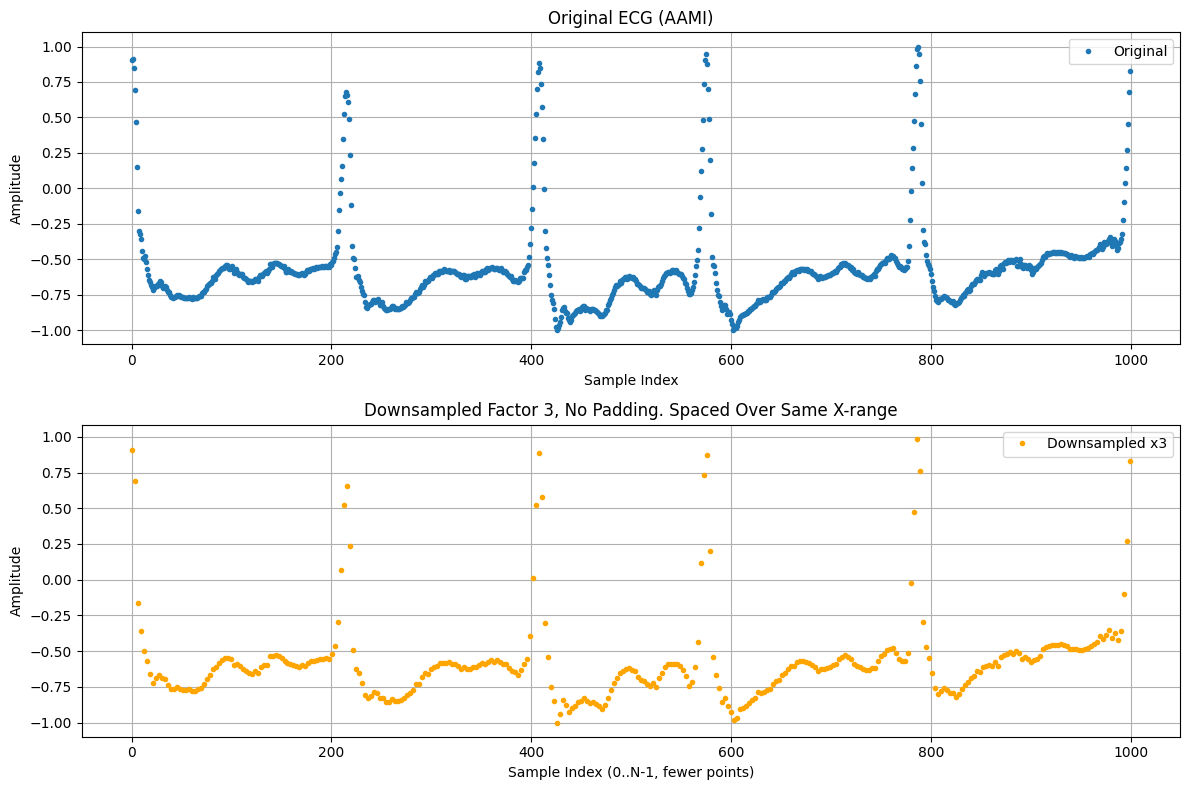

In [ ]:
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_random_multibeat_window_hrx3(dataset, label_filter=None, title_label='raw', figsize=(12, 8)):
    """
    Two subplots:
      1) Original resampled ECG window as discrete points ('o').
      2) A downsampled version (by factor 3, skipping 2/3 of samples),
         also plotted as discrete points, but stretched across the same x-range.
         => No sample padding or repetition. We just have fewer points
            spaced out over the same horizontal domain.

    So the second subplot "looks" like a 3× faster wave but with fewer points.
    """

    assert title_label in ['raw', 'aami'], "title_label must be 'raw' or 'aami'"

    # 1. Filter events if needed
    if label_filter:
        if isinstance(label_filter, str):
            label_filter = [label_filter]
        filtered_events = [e for e in dataset.labeled_events if e[2] in label_filter]
        if not filtered_events:
            print(f"❌ No samples found with label(s): {label_filter}")
            return
    else:
        filtered_events = dataset.labeled_events

    # 2. Pick a random event
    filename, ecg_tensor, raw_label, sample_num = random.choice(filtered_events)
    ecg_np = ecg_tensor.squeeze().numpy()  # shape ~ (N,)

    # 3. Setup figure
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=figsize)

    # -----------------
    # (A) Original wave
    # -----------------
    N = len(ecg_np)
    ax1.plot(np.arange(N), ecg_np, 'o', markersize=3, label="Original")
    ax1.set_title("Original ECG" if title_label=='raw' else "Original ECG (AAMI)")  # or adapt with your label logic
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Amplitude")
    ax1.grid(True)
    ax1.legend()

    # If you want to mark R-peaks from the dataset => do that:
    # ... (similar to your old code)
    # We'll skip that here for brevity – you can copy from your prior snippet.

    # -----------------
    # (B) Downsample by factor 3, space out
    # -----------------
    # Keep every 3rd sample => length ~ N/3
    ecg_ds = ecg_np[::3]
    M = len(ecg_ds)

    # Create an x-axis that spans the same 0..(N-1) range, but only has M points
    x_ds = np.linspace(0, N-1, M)
    # So the first point is x=0, last is x=N-1, in between are M-2 equally spaced points

    ax2.plot(x_ds, ecg_ds, 'o', markersize=3, color='orange', label="Downsampled x3")
    ax2.set_title("Downsampled Factor 3, No Padding. Spaced Over Same X-range")
    ax2.set_xlabel("Sample Index (0..N-1, fewer points)")
    ax2.set_ylabel("Amplitude")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()


plot_random_multibeat_window_hrx3(dataset, title_label='aami')
